# Metodología para la Estimación y Modelamiento de la DNI, la DHI y la POA a partir de la GHI y producción de una planta solar Fotovoltaica.

In [1]:
import pvlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error

ModuleNotFoundError: No module named 'pvlib'

In [ ]:
tz = 'America/Bogota'
lat, lon = 9.789103, -73.722451 # 9.789103, -73.722451 Esta es las coordenas
altitude = 50

In [ ]:
#Ubicación Geográfica
location = pvlib.location.Location(lat, lon, tz, altitude)


In [ ]:
times = pd.date_range('2020-01-01 00:00:00', '2021-01-01', closed='left',
                      freq='H', tz=tz)
solpos = pvlib.solarposition.get_solarposition(times, lat, lon)
# remove nighttime
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

In [ ]:
api_key = 'xxxxxx_api_key'
email = 'xxxxxxxxx@uniandes.edu.co'

In [ ]:
elpaso_tmy, header = pvlib.iotools.get_psm3(lat, lon, api_key, email, 
                                                   names='tmy')

In [ ]:
print(header)
elpaso_tmy.head()

{'Source': 'NSRDB', 'Location ID': '1253063', 'City': '-', 'State': '-', 'Country': '-', 'Latitude': 9.77, 'Longitude': -73.74, 'Time Zone': -5, 'Elevation': 67, 'Local Time Zone': -5, 'Dew Point Units': 'c', 'DHI Units': 'w/m2', 'DNI Units': 'w/m2', 'GHI Units': 'w/m2', 'Temperature Units': 'c', 'Pressure Units': 'mbar', 'Wind Direction Units': 'Degrees', 'Wind Speed Units': 'm/s', 'Surface Albedo Units': 'N/A', 'Version': '3.2.0'}


,Year,Month,Day,Hour,Minute,Temperature,Dew Point,DHI,DNI,GHI,Surface Albedo,Pressure,Wind Direction,Wind Speed
2007-01-01 00:30:00-05:00,2007,1,1,0,30,24.0,19.0,0.0,0.0,0.0,0.2,990.0,69.0,0.1
2007-01-01 01:30:00-05:00,2007,1,1,1,30,24.0,19.0,0.0,0.0,0.0,0.2,990.0,86.0,0.1
2007-01-01 02:30:00-05:00,2007,1,1,2,30,24.0,19.0,0.0,0.0,0.0,0.2,990.0,122.0,0.0
2007-01-01 03:30:00-05:00,2007,1,1,3,30,23.0,19.0,0.0,0.0,0.0,0.2,990.0,129.0,0.0
2007-01-01 04:30:00-05:00,2007,1,1,4,30,23.0,19.0,0.0,0.0,0.0,0.2,990.0,134.0,0.0


In [ ]:
'''
Common plots set-up function.
'''
def plot_specs(title, ylabel, xlabel, rot, ylim_min, 
    ylim_max, xlim_min, xlim_max, loc):
    plt.rc('font', family='Helvetica')
    plt.rcParams['axes.axisbelow'] = True;
    
    plt.title(title, fontname="Helvetica", fontsize=15);
    plt.ylabel(ylabel, fontname="Helvetica", fontsize=13);
    plt.xlabel(xlabel, fontname="Helvetica", fontsize=13);
    
    plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
    plt.xticks(rotation=rot)
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min, xlim_max)
    plt.grid(True);
    plt.legend(loc=loc, fontsize=9);
    plt.tight_layout;

'''
Statistic Metrics
'''
def median_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def metrics(r2, measured, modeled, store):
    print('R2: ', r2.round(4))

    metrics_df = pd.DataFrame({'measured': measured, 
                               'modeled': modeled})

    y_true = metrics_df.measured
    y_pred = metrics_df.modeled

    rmse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
    rmse = (rmse/np.max(y_true))*100
    print('RMSE: ', np.round(rmse, 2))

    '''
    MAPE requires to filter the data when y_true=0 --> (y_true - y_pred)/y_true
    '''
    metrics_df = metrics_df.loc[(metrics_df.index.hour >= 7) & (metrics_df.index.hour <= 17) & (metrics_df.measured != 0)]

    y_true = metrics_df.measured
    y_pred = metrics_df.modeled

    mape = median_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
    print('MAPE: ', np.round(mape, 2))
    
    if store == True:
        list_r2.append(r_value)
        list_rmse.append(rmse)
        list_mape.append(mape)

#### 5.2.1. Seguidor de Un Eje (Single-Axis Tracker)

Determina el ángulo de rotación de un seguidor de un solo eje (*single-axis tracker*) a partir de los ángulos de azimut y cenit solar instantánteos.

La gráfica presenta un solo día de funcionamiento del seguidor. El eje-y muestra la rotación del rastreador desde la horizontal (i.e. 0 grados significa paneles 'planos'). Por la mañana, los seguidores giran en ángulos negativos para mirar al este hacia el sol de la mañana; de manera equivalente, por la tarde giran en ángulos positivos para mirar al oeste hacia el sol. A mediodía los paneles están 'planos' pues el sol se ubica en la parte más alta del cielo.

**Info 1 (Tutorial de Clase Tracking):** https://pvsc-python-tutorials.github.io/PVSC48-Python-Tutorial/Tutorial%202%20-%20POA%20Irradiance.html.

**Info 2:** https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.tracking.singleaxis.html.

In [ ]:
tracker = pvlib.tracking.singleaxis(apparent_zenith=solpos.apparent_zenith, 
                                    apparent_azimuth=solpos.azimuth, 
                                    axis_tilt=0,
                                    axis_azimuth=180, #Heading south
                                    max_angle=45, 
                                    backtrack=True, 
                                    gcr=0.2857142857142857)

tracker = tracker.fillna(0)
tracker.head()

,tracker_theta,aoi,surface_azimuth,surface_tilt
Datetime,,,,
2020-06-01 05:35:00-05:00,-0.399164,89.483947,90.0,0.399164
2020-06-01 05:36:00-05:00,-0.918352,88.812394,90.0,0.918352
2020-06-01 05:37:00-05:00,-1.444087,88.132054,90.0,1.444087
2020-06-01 05:38:00-05:00,-1.976972,87.442205,90.0,1.976972
2020-06-01 05:39:00-05:00,-2.517115,86.742767,90.0,2.517115


Max. angle:  45.0
Min. angle:  -45.0


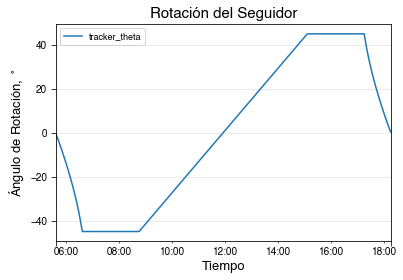

In [ ]:
fecha = '2020-06-17 '

tracker.tracker_theta.loc[fecha+'00:00:00':fecha+'23:59:00'].plot()

plot_specs(title='Rotación del Seguidor',
           ylabel='Ángulo de Rotación, $^\circ$',
           xlabel='Tiempo',
           rot=0, 
           ylim_min=None, ylim_max=None, 
           xlim_min=None, xlim_max=None, 
           loc='best')

print('Max. angle: ', max(tracker.tracker_theta))
print('Min. angle: ', min(tracker.tracker_theta))

### 4.2. Airmass

La clase Atmosphere envuelve una variedad de modelos para obtener los datos de la masa de aire. Algunos de los modelos son: (i.) **Simple**, (ii.) **Kasten 1966**, (iii.) **Young-Irvine 1967**, (iv.) **Kasten-Young 1989**, (v.) **Gueymard 1993**, **Young 1994** y **Pickering 2002**.

El modelo predeterminado es **Kasten-Young 1989**.

**Info 1 (Tutorial de Clase Atmosphere):** https://nbviewer.jupyter.org/github/pvlib/pvlib-python/blob/master/docs/tutorials/atmosphere.ipynb.

**Info 2:** https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.location.Location.get_airmass.html.

In [ ]:
airmass = location.get_airmass(times=elpasoDB.index, 
                               solar_position=solpos, 
                               model='kastenyoung1989')

airmass.head()

,airmass_relative,airmass_absolute
Datetime,,
2020-06-01 05:35:00-05:00,35.802637,35.590910
2020-06-01 05:36:00-05:00,33.276773,33.079983
2020-06-01 05:37:00-05:00,30.966339,30.783212
2020-06-01 05:38:00-05:00,28.857457,28.686802
2020-06-01 05:39:00-05:00,26.935888,26.776597


### 4.3. DNI Extraterrestre

Muchos algoritmos de energía solar comienzan con la irradiancia incidente en la parte superior de la atmósfera de la Tierra, a menudo conocida como radiación extraterrestre. ```PVLIB-Python``` tiene cuatro algoritmos diferentes para calcular el ciclo anual de la radiación extraterrestre dada la constante solar.

Por defecto, el método es **Spencer**. Sin embargo, se utiliza **NREL** por ser más preciso y computacionalmente eficiente [1].

El usuario también puede controlar la constante solar. La literatura reciente sugiere que la constante solar es $1361 \: W / m ^ 2$ en lugar de los $1367 \: W / m ^ 2$ comúnmente aceptados.

**Los métodos PyEphem y NREL son los más precisos**. No obstante, la diferencia entre ellos y el método de Spencer (por defecto) es tan solo $\pm \: 2 \: W/m^2$ (máximo) durante todo el año. La diferencia entre PyEphem y NREL es despreciable.

---

[1] W. Holmgren (2018). irradiance.py tutorial, notebook.community, , University of Arizona. [online]. Retrieved from: https://notebook.community/rubennj/pvlib-python/docs/tutorials/irradiance.

---

In [ ]:
etr_nrel = pvlib.irradiance.get_extra_radiation(datetime_or_doy=elpasoDB.index, 
                                          method='NREL', 
                                          solar_constant=1361);

#### 5.2.2. Irradiancia POA <span style='color:White'>code:5</span>

Determina la irradiancia total en el plano y sus componentes (directo, cielo difuso y suelo difuso) haz, utilizando el modelo de irradiancia difusa del cielo Perez-Ineichen 1990.

$$
I_{POA} = I_{directa} + I_{cielo \: dif} + I_{suelo \: dif}
$$

**Info:** https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.irradiance.get_total_irradiance.html.

In [ ]:
surface_albedo = pvlib.irradiance.SURFACE_ALBEDOS['soil']; # Check the surfaces albedo list with print(irradiance.SURFACE_ALBEDOS.items()) function

poa_perez = pvlib.irradiance.get_total_irradiance(surface_tilt=tracker.surface_tilt, 
                                            surface_azimuth=tracker.surface_azimuth, 
                                            solar_zenith=solpos.zenith, 
                                            solar_azimuth=solpos.azimuth, 
                                            dni=disc.dni, 
                                            ghi=elpasoDB.ghi, 
                                            dhi=disc.dhi, 
                                            dni_extra=etr_nrel, 
                                            airmass=airmass.airmass_relative, 
                                            albedo=surface_albedo, 
                                            surface_type='soil', 
                                            model='perez', 
                                            model_perez='allsitescomposite1990')

poa_effective = poa_perez.copy()

poa_perez.head()

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
Datetime,,,,,
2020-06-01 05:35:00-05:00,2.997570,-0.0,2.997570,2.997564,0.000006
2020-06-01 05:36:00-05:00,3.426565,0.0,3.426565,3.426527,0.000037
2020-06-01 05:37:00-05:00,4.113195,0.0,4.113195,4.113084,0.000111
2020-06-01 05:38:00-05:00,4.109308,0.0,4.109308,4.109100,0.000209
2020-06-01 05:39:00-05:00,4.621286,0.0,4.621286,4.620906,0.000381


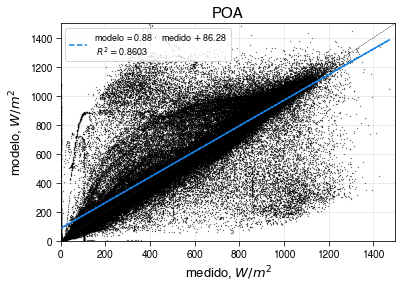

R2:  0.8603
RMSE:  13.13
MAPE:  9.32


In [ ]:
fecha_ini = '2020-06-01 00:00:00-05:00'
fecha_fin = '2020-12-31 23:59:00-05:00'

irrads = pd.DataFrame({'medido': elpasoDB.loc[fecha_ini:fecha_fin]['poa1'], 
            'modelo': poa_perez.loc[fecha_ini:fecha_fin]['poa_global']})

irrads = irrads.dropna()
#Least Squares Linear Regression
x_value = irrads.medido
y_value = irrads.modelo

coef = np.polyfit(x_value, y_value, 1)
poly1d_fn = np.poly1d(coef)

slope, intercept, r_value, p_value, std_err = stats.linregress(x_value, 
                                                                  y_value)

#Figure
axis_lim = 1500

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope*x + intercept
                        
plt.figure()
plt.plot(x_value, 
            poly1d_fn(x_value), 
            '--',
            label=('modelo = ' + 
                  f'{slope.round(2)} $· \:$ medido $+ \:$' + 
                  f'{intercept.round(2)} \n $R^2 = $' 
                  + f'{r_value.round(4)}'), 
            color='#1580E4', linewidth=1.5, zorder = 10)

plt.plot(x_value, y_value, color='black', ls='', 
            marker='.', ms=0.5, fillstyle='none')

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plot_specs(title=f'POA',
            ylabel='modelo, $W/m^2$',
            xlabel='medido, $W/m^2$',
            rot=0, 
            ylim_min=0, ylim_max=axis_lim, 
            xlim_min=0, xlim_max=axis_lim, 
            loc='best')
                        
plt.show()
                        
#METRICS
metrics(r2=r_value, measured=x_value, modeled=y_value, store=False)

### 8.1. Resampleo 1-min a 5-min

In [ ]:
elpasoDB_5min = elpasoDB.copy()

elpasoDB_5min = elpasoDB_5min.resample('5Min').mean()
#Solar Position
solpos_5min = location.get_solarposition(times=elpasoDB_5min.index, 
                                    method='nrel_numpy')

#Airmass
airmass_5min = location.get_airmass(times=elpasoDB_5min.index, 
                            solar_position=solpos_5min, model='kastenyoung1989')

#Extraterrestrial DNI
etr_nrel_5min = pvlib.irradiance.get_extra_radiation(datetime_or_doy=elpasoDB_5min.index, 
            method='NREL', solar_constant=1361)

elpasoDB_5min.head()

,temp_air,pressure,humidity,wind_direction,wind_speed,ghi_2,ghi,dhi,rain,poa1,...,poa5,poa6,poa7,poa8,poa9,poa10,poa11,poa12,poa_mean,dni
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-06-01 05:35:00-05:00,24.933289,1005.916272,97.238823,26.695231,0.297728,4.088474,3.863547,3.045511,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165.867072
2020-06-01 05:40:00-05:00,24.938947,1005.971826,97.293393,26.568933,0.654417,7.072035,6.887484,5.441345,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.335834
2020-06-01 05:45:00-05:00,24.907465,1005.936743,97.279366,45.481563,0.803581,13.886820,13.246786,10.660005,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.543974
2020-06-01 05:50:00-05:00,24.876611,1006.047852,97.231023,32.235980,0.898503,20.754541,20.314464,16.731876,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.109954
2020-06-01 05:55:00-05:00,24.942090,1006.027380,97.266109,41.448104,0.496413,29.670190,29.162081,23.919789,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.300942


In [ ]:
#Original DISC: Relative Airmass
disc_5min = pvlib.irradiance.disc(ghi=elpasoDB_5min.ghi, 
                               solar_zenith=solpos_5min.zenith, 
                               datetime_or_doy=elpasoDB_5min.index, 
                               pressure=None, #Absolute Airmass: 101325, Relative Airmass: None (elpasoDB.pressure*100)
                               min_cos_zenith=0.065, 
                               max_zenith=87, #80
                               max_airmass=12) #Max airmass value to allow in Kt calc; value 12 comes from original paper.

disc_5min['dhi'] = elpasoDB_5min.ghi - disc_5min.dni*np.cos(np.radians(solpos_5min.zenith))

disc_5min.head()

,dni,kt,airmass,dhi
Datetime,,,,
2020-06-01 05:35:00-05:00,0.00000,0.044662,NaN,3.863547
2020-06-01 05:40:00-05:00,0.00000,0.079619,12.000000,6.887484
2020-06-01 05:45:00-05:00,0.00000,0.153132,12.000000,13.246786
2020-06-01 05:50:00-05:00,0.00000,0.234833,12.000000,20.314464
2020-06-01 05:55:00-05:00,61.36634,0.301164,11.941866,24.697165


In [ ]:
tracker_5min = pvlib.tracking.singleaxis(apparent_zenith=solpos_5min.apparent_zenith, 
                                      apparent_azimuth=solpos_5min.azimuth, 
                                      axis_tilt=0,
                                      axis_azimuth=180, #Heading south
                                      max_angle=45, 
                                      backtrack=True, 
                                      gcr=0.2857142857142857)

In [ ]:
poa_perez_5min = pvlib.irradiance.get_total_irradiance(surface_tilt=tracker_5min.surface_tilt, 
                                            surface_azimuth=tracker_5min.surface_azimuth, 
                                            solar_zenith=solpos_5min.zenith, 
                                            solar_azimuth=solpos_5min.azimuth, 
                                            dni=disc_5min.dni, 
                                            ghi=elpasoDB_5min.ghi, 
                                            dhi=disc_5min.dhi, 
                                            dni_extra=etr_nrel_5min, 
                                            airmass=airmass_5min.airmass_relative, 
                                            albedo=surface_albedo, 
                                            surface_type='soil', 
                                            model='perez', 
                                            model_perez='allsitescomposite1990')

poa_perez_5min.head()

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
Datetime,,,,,
2020-06-01 05:35:00-05:00,3.861162,-0.000000,3.861162,3.861154,0.000008
2020-06-01 05:40:00-05:00,6.852162,0.000000,6.852162,6.851325,0.000837
2020-06-01 05:45:00-05:00,13.144220,0.000000,13.144220,13.138266,0.005954
2020-06-01 05:50:00-05:00,20.655759,0.000000,20.655759,20.635171,0.020588
2020-06-01 05:55:00-05:00,49.202958,16.120422,33.082536,33.028969,0.053567


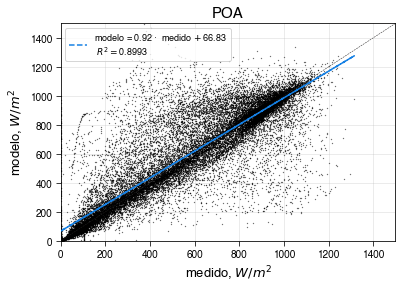

R2:  0.8993
RMSE:  12.22
MAPE:  9.7


In [ ]:
fecha_ini = '2020-06-01 00:00:00-05:00'
fecha_fin = '2020-12-31 23:59:00-05:00'

irrads = pd.DataFrame({'medido': elpasoDB_5min.loc[fecha_ini:fecha_fin]['poa1'], 
            'modelo': poa_perez_5min.loc[fecha_ini:fecha_fin]['poa_global']})

irrads = irrads.dropna()
#Least Squares Linear Regression
x_value = irrads.medido
y_value = irrads.modelo

coef = np.polyfit(x_value, y_value, 1)
poly1d_fn = np.poly1d(coef)

slope, intercept, r_value, p_value, std_err = stats.linregress(x_value, 
                                                                  y_value)

#Figure
axis_lim = 1500

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope*x + intercept
                        
plt.figure()
plt.plot(x_value, 
            poly1d_fn(x_value), 
            '--',
            label=('modelo = ' + 
                  f'{slope.round(2)} $· \:$ medido $+ \:$' + 
                  f'{intercept.round(2)} \n $R^2 = $' 
                  + f'{r_value.round(4)}'), 
            color='#1580E4', linewidth=1.5, zorder = 10)

plt.plot(x_value, y_value, color='black', ls='', 
            marker='.', ms=0.5, fillstyle='none')

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plot_specs(title=f'POA',
            ylabel='modelo, $W/m^2$',
            xlabel='medido, $W/m^2$',
            rot=0, 
            ylim_min=0, ylim_max=axis_lim, 
            xlim_min=0, xlim_max=axis_lim, 
            loc='best')
                        
plt.show()
                        
#METRICS
metrics(r2=r_value, measured=x_value, modeled=y_value, store=False)

### 9.1. Resampleo 1-min a 10-min

In [ ]:
elpasoDB_10min = elpasoDB.copy()

elpasoDB_10min = elpasoDB_10min.resample('10Min').mean()
#Solar Position
solpos_10min = location.get_solarposition(times=elpasoDB_10min.index, 
                                    method='nrel_numpy')

#Airmass
airmass_10min = location.get_airmass(times=elpasoDB_10min.index, 
                            solar_position=solpos_10min, model='kastenyoung1989')

#Extraterrestrial DNI
etr_nrel_10min = pvlib.irradiance.get_extra_radiation(datetime_or_doy=elpasoDB_10min.index, 
            method='NREL', solar_constant=1361)

elpasoDB_10min.head()

,temp_air,pressure,humidity,wind_direction,wind_speed,ghi_2,ghi,dhi,rain,poa1,...,poa5,poa6,poa7,poa8,poa9,poa10,poa11,poa12,poa_mean,dni
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-06-01 05:30:00-05:00,24.933289,1005.916272,97.238823,26.695231,0.297728,4.088474,3.863547,3.045511,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,165.867072
2020-06-01 05:40:00-05:00,24.923206,1005.954285,97.286379,36.025248,0.728999,10.479428,10.067135,8.050675,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,65.439904
2020-06-01 05:50:00-05:00,24.909351,1006.037616,97.248566,36.842042,0.697458,25.212366,24.738272,20.325833,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,65.705448
2020-06-01 06:00:00-05:00,24.974530,1006.046387,97.133556,58.562941,0.758480,51.032494,49.604871,40.494494,0.12,54.298294,...,58.387872,58.387872,58.387872,55.729460,55.729460,58.691793,55.975564,55.975564,56.313437,92.627262
2020-06-01 06:10:00-05:00,25.157501,1006.046387,96.871588,64.176664,0.566575,70.973528,68.492448,56.019006,0.20,76.206285,...,81.567091,81.567091,81.567091,78.732568,78.732568,79.434824,80.323736,80.323736,78.965274,98.619818


In [ ]:
### 9.3. Descomposición: DISC
#Original DISC: Relative Airmass
disc_10min = pvlib.irradiance.disc(ghi=elpasoDB_10min.ghi, 
                                solar_zenith=solpos_10min.zenith, 
                                datetime_or_doy=elpasoDB_10min.index, 
                                pressure=None, #Absolute Airmass: 101325, Relative Airmass: None (elpasoDB.pressure*100)
                                min_cos_zenith=0.065, 
                                max_zenith=87, #80
                                max_airmass=12) #Max airmass value to allow in Kt calc; value 12 comes from original paper.

disc_10min['dhi'] = elpasoDB_10min.ghi - disc_10min.dni*np.cos(np.radians(solpos_10min.zenith))

disc_10min.head()

,dni,kt,airmass,dhi
Datetime,,,,
2020-06-01 05:30:00-05:00,0.000000,0.044662,NaN,3.863547
2020-06-01 05:40:00-05:00,0.000000,0.116375,12.000000,10.067135
2020-06-01 05:50:00-05:00,42.464583,0.285972,12.000000,22.494157
2020-06-01 06:00:00-05:00,216.450662,0.402228,9.807489,29.547297
2020-06-01 06:10:00-05:00,190.370370,0.388619,7.170251,43.281697


In [ ]:
### 9.4. Transposición: Perez-Ineichen 1990

tracker_10min = pvlib.tracking.singleaxis(apparent_zenith=solpos_10min.apparent_zenith, 
                                       apparent_azimuth=solpos_10min.azimuth, 
                                       axis_tilt=0,
                                       axis_azimuth=180, #Heading south
                                       max_angle=45, 
                                       backtrack=True, 
                                       gcr=0.2857142857142857)

tracker_10min = tracker_10min.fillna(0)

In [ ]:
poa_perez_10min = pvlib.irradiance.get_total_irradiance(surface_tilt=tracker_10min.surface_tilt, 
                                            surface_azimuth=tracker_10min.surface_azimuth, 
                                            solar_zenith=solpos_10min.zenith, 
                                            solar_azimuth=solpos_10min.azimuth, 
                                            dni=disc_10min.dni, 
                                            ghi=elpasoDB_10min.ghi, 
                                            dhi=disc_10min.dhi, 
                                            dni_extra=etr_nrel_10min, 
                                            airmass=airmass_10min.airmass_relative, 
                                            albedo=surface_albedo, 
                                            surface_type='soil', 
                                            model='perez', 
                                            model_perez='allsitescomposite1990')

poa_perez_10min.head()

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
Datetime,,,,,
2020-06-01 05:30:00-05:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2020-06-01 05:40:00-05:00,9.994862,0.000000,9.994862,9.993638,0.001224
2020-06-01 05:50:00-05:00,33.814358,8.272414,25.541944,25.516873,0.025071
2020-06-01 06:00:00-05:00,121.301671,71.667194,49.634477,49.488303,0.146175
2020-06-01 06:10:00-05:00,162.473716,89.218750,73.254965,72.831366,0.423599


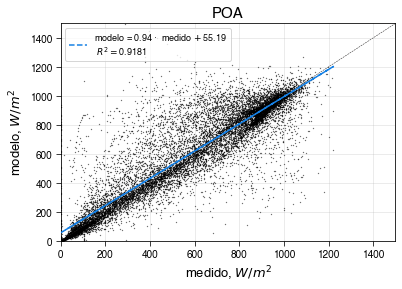

R2:  0.9181
RMSE:  11.82
MAPE:  9.84


In [ ]:
fecha_ini = '2020-06-01 00:00:00-05:00'
fecha_fin = '2020-12-31 23:59:00-05:00'

irrads = pd.DataFrame({'medido': elpasoDB_10min.loc[fecha_ini:fecha_fin]['poa1'], 
            'modelo': poa_perez_10min.loc[fecha_ini:fecha_fin]['poa_global']})

irrads = irrads.dropna()
#Least Squares Linear Regression
x_value = irrads.medido
y_value = irrads.modelo

coef = np.polyfit(x_value, y_value, 1)
poly1d_fn = np.poly1d(coef)

slope, intercept, r_value, p_value, std_err = stats.linregress(x_value, 
                                                                  y_value)

#Figure
axis_lim = 1500

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope*x + intercept
                        
plt.figure()
plt.plot(x_value, 
            poly1d_fn(x_value), 
            '--',
            label=('modelo = ' + 
                  f'{slope.round(2)} $· \:$ medido $+ \:$' + 
                  f'{intercept.round(2)} \n $R^2 = $' 
                  + f'{r_value.round(4)}'), 
            color='#1580E4', linewidth=1.5, zorder = 10)

plt.plot(x_value, y_value, color='black', ls='', 
            marker='.', ms=0.5, fillstyle='none')

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plot_specs(title=f'POA',
            ylabel='modelo, $W/m^2$',
            xlabel='medido, $W/m^2$',
            rot=0, 
            ylim_min=0, ylim_max=axis_lim, 
            xlim_min=0, xlim_max=axis_lim, 
            loc='best')
                        
plt.show()
                        
#METRICS
metrics(r2=r_value, measured=x_value, modeled=y_value, store=False)

### 10.1. Resampleo 1-min a 60-min

In [ ]:
elpasoDB_60min = elpasoDB.copy()

elpasoDB_60min = elpasoDB_60min.resample('60Min').mean()
#Solar Position
solpos_60min = location.get_solarposition(times=elpasoDB_60min.index, 
                                    method='nrel_numpy')

#Airmass
airmass_60min = location.get_airmass(times=elpasoDB_60min.index, 
                            solar_position=solpos_60min, model='kastenyoung1989')

#Extraterrestrial DNI
etr_nrel_60min = pvlib.irradiance.get_extra_radiation(datetime_or_doy=elpasoDB_60min.index, 
            method='NREL', solar_constant=1361)

elpasoDB_60min.head()

,temp_air,pressure,humidity,wind_direction,wind_speed,ghi_2,ghi,dhi,rain,poa1,...,poa5,poa6,poa7,poa8,poa9,poa10,poa11,poa12,poa_mean,dni
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-06-01 05:00:00-05:00,24.919680,1005.980015,97.261743,34.485962,0.630128,15.094412,14.694872,11.959705,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,85.631555
2020-06-01 06:00:00-05:00,25.514718,1006.141891,94.791844,69.180366,0.493860,122.587260,116.779828,93.093360,0.103333,141.237631,...,155.329329,155.329329,155.329329,159.873660,159.873660,155.735133,143.963133,143.963133,149.904111,132.714761
2020-06-01 07:00:00-05:00,26.768879,1006.740057,86.930553,122.429792,0.148471,205.729450,200.844985,160.133584,0.000000,173.021353,...,189.704854,189.704854,189.704854,187.353840,187.353840,163.554182,194.994056,194.994056,184.467892,103.373528
2020-06-01 08:00:00-05:00,27.715400,1007.105030,82.420734,143.542899,0.287264,279.249809,271.899395,222.257436,0.000000,245.555582,...,263.934447,263.934447,263.934447,252.114648,252.114648,226.686017,242.552894,242.552894,249.363810,88.552875
2020-06-01 09:00:00-05:00,29.172182,1007.194214,74.525395,220.674420,0.358406,450.276014,437.162579,353.589068,0.000000,515.886620,...,514.780418,514.780418,514.780418,454.367489,454.367489,407.014902,438.380915,438.380915,477.415711,120.074383


In [ ]:
### 9.3. Descomposición: DISC
#Original DISC: Relative Airmass
disc_60min = pvlib.irradiance.disc(ghi=elpasoDB_60min.ghi, 
                                solar_zenith=solpos_60min.zenith, 
                                datetime_or_doy=elpasoDB_60min.index, 
                                pressure=None, #Absolute Airmass: 101325, Relative Airmass: None (elpasoDB.pressure*100)
                                min_cos_zenith=0.065, 
                                max_zenith=87, #80
                                max_airmass=12) #Max airmass value to allow in Kt calc; value 12 comes from original paper.

disc_60min['dhi'] = elpasoDB_60min.ghi - disc_60min.dni*np.cos(np.radians(solpos_60min.zenith))

disc_60min.head()

,dni,kt,airmass,dhi
Datetime,,,,
2020-06-01 05:00:00-05:00,0.000000,0.169871,NaN,14.694872
2020-06-01 06:00:00-05:00,411.714227,0.946926,9.807489,78.628001
2020-06-01 07:00:00-05:00,247.516858,0.460395,3.023535,119.711001
2020-06-01 08:00:00-05:00,77.386971,0.374913,1.829601,229.728461
2020-06-01 09:00:00-05:00,132.007544,0.450403,1.369112,340.888825


In [ ]:
### 9.4. Transposición: Perez-Ineichen 1990

tracker_60min = pvlib.tracking.singleaxis(apparent_zenith=solpos_60min.apparent_zenith, 
                                       apparent_azimuth=solpos_60min.azimuth, 
                                       axis_tilt=0,
                                       axis_azimuth=180, #Heading south
                                       max_angle=45, 
                                       backtrack=True, 
                                       gcr=0.2857142857142857)

tracker_60min = tracker_60min.fillna(0)

In [ ]:
poa_perez_60min = pvlib.irradiance.get_total_irradiance(surface_tilt=tracker_60min.surface_tilt, 
                                            surface_azimuth=tracker_60min.surface_azimuth, 
                                            solar_zenith=solpos_60min.zenith, 
                                            solar_azimuth=solpos_60min.azimuth, 
                                            dni=disc_60min.dni, 
                                            ghi=elpasoDB_60min.ghi, 
                                            dhi=disc_60min.dhi, 
                                            dni_extra=etr_nrel_60min, 
                                            airmass=airmass_60min.airmass_relative, 
                                            albedo=surface_albedo, 
                                            surface_type='soil', 
                                            model='perez', 
                                            model_perez='allsitescomposite1990')

poa_perez_60min.head()

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
Datetime,,,,,
2020-06-01 05:00:00-05:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2020-06-01 06:00:00-05:00,236.667256,136.319303,100.347953,100.003829,0.344124
2020-06-01 07:00:00-05:00,377.739429,212.559615,165.179813,160.179592,5.000221
2020-06-01 08:00:00-05:00,310.937900,72.895747,238.042153,231.272967,6.769187
2020-06-01 09:00:00-05:00,489.821672,127.573646,362.248027,353.137819,9.110208


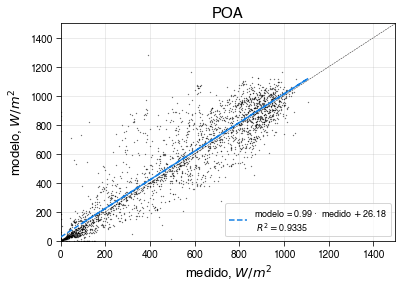

R2:  0.9335
RMSE:  11.89
MAPE:  14.24


In [ ]:
fecha_ini = '2020-06-01 00:00:00-05:00'
fecha_fin = '2020-12-31 23:59:00-05:00'

irrads = pd.DataFrame({'medido': elpasoDB_60min.loc[fecha_ini:fecha_fin]['poa1'], 
            'modelo': poa_perez_60min.loc[fecha_ini:fecha_fin]['poa_global']})

irrads = irrads.dropna()
#Least Squares Linear Regression
x_value = irrads.medido
y_value = irrads.modelo

coef = np.polyfit(x_value, y_value, 1)
poly1d_fn = np.poly1d(coef)

slope, intercept, r_value, p_value, std_err = stats.linregress(x_value, 
                                                                  y_value)

#Figure
axis_lim = 1500

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope*x + intercept
                        
plt.figure()
plt.plot(x_value, 
            poly1d_fn(x_value), 
            '--',
            label=('modelo = ' + 
                  f'{slope.round(2)} $· \:$ medido $+ \:$' + 
                  f'{intercept.round(2)} \n $R^2 = $' 
                  + f'{r_value.round(4)}'), 
            color='#1580E4', linewidth=1.5, zorder = 10)

plt.plot(x_value, y_value, color='black', ls='', 
            marker='.', ms=0.5, fillstyle='none')

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plot_specs(title=f'POA',
            ylabel='modelo, $W/m^2$',
            xlabel='medido, $W/m^2$',
            rot=0, 
            ylim_min=0, ylim_max=axis_lim, 
            xlim_min=0, xlim_max=axis_lim, 
            loc='best')
                        
plt.show()
                        
#METRICS
metrics(r2=r_value, measured=x_value, modeled=y_value, store=False)

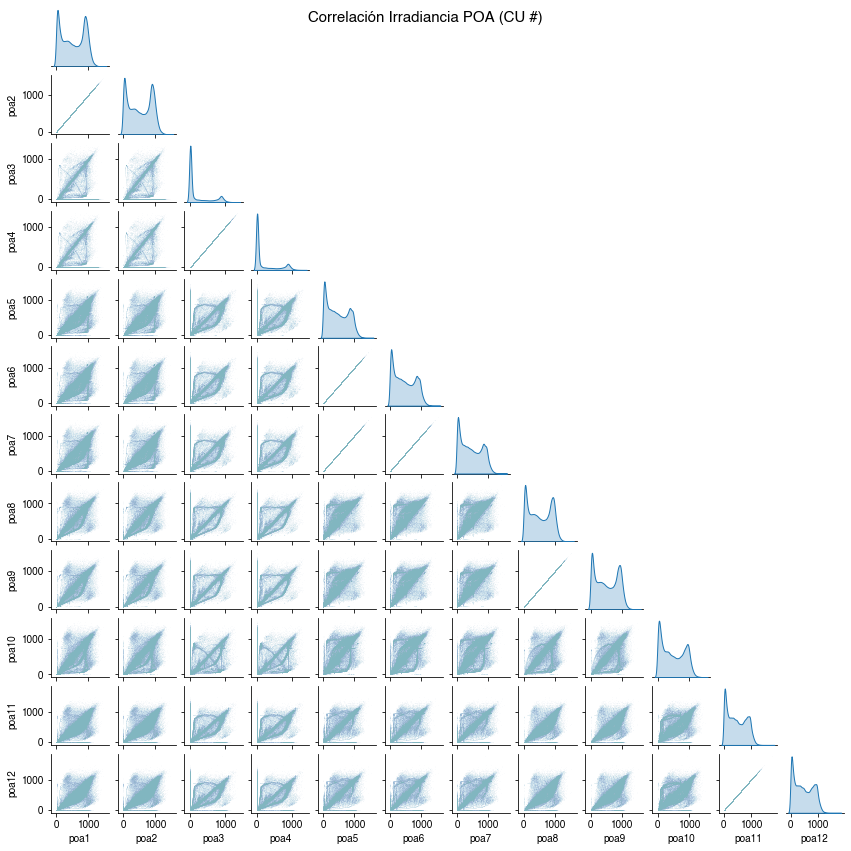

In [ ]:
sns.pairplot(elpasoDB[elpasoDB.columns[9:21]], 
             corner=True, 
             diag_kind='kde', 
             plot_kws=dict(marker='.', s=0.1),
             height=1);

plt.suptitle('Correlación Irradiancia POA (CU #)', size=15);

## 11. Configuración del Sistema <span style='color:White'>code:23</span>

### 11.1. Datos de Potencia

In [ ]:
#Grab Excel Files Only
pattern = './EL_PASO/II_semestre_2020_ac/*/*.xlsx'

#Save All File Matches: xlsx_files
xlsx_files = glob.glob(pattern)
xlsx_files.sort()

#Create an empty list: frames
frames = []

#Iterate Over xlsx_files
for filename in xlsx_files:
    #METEOST
    names = ['Datetime', 'el_paso', 'la_cuna', 'linea_1', 'linea_2', 'linea_3', 'linea_4']
    columns = [1, 2, 3, 4, 5, 6, 7]
    
    df = pd.read_excel(filename, sheet_name=1, header=11, names=names, usecols=columns, skiprows=1)
    df = df.set_index('Datetime')
    df = df[:-1]

    #Append df to Frames
    frames.append(df)

#Concatenate Frames into Dataframe
elpaso_pac = pd.concat(frames).drop_duplicates()
elpaso_pac = elpaso_pac.sort_index()
elpaso_pac = elpaso_pac.tz_localize(tz)

#Calculate solar position parameters
solpos = location.get_solarposition(times=elpaso_pac.index,
                                    method='nrel_numpy')

elpaso_pac = elpaso_pac.loc[solpos['apparent_elevation'] > 0, :]
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

#Concatenate with elpasoDB
# elpasoDB.drop(['poa_mean'], axis=1, inplace=True)
# elpasoDB = pd.concat([elpasoDB, elpaso_pac], axis=1)
# elpasoDB = elpasoDB.fillna(0)

elpaso_pac.head()

,el_paso,la_cuna,linea_1,linea_2,linea_3,linea_4
Datetime,,,,,,
2020-06-01 06:01:00-05:00,2.861268,2.871098,0.982695,0.924126,0.0,1.021810
2020-06-01 06:02:00-05:00,3.149251,3.148716,1.083606,1.009556,0.0,1.114363
2020-06-01 06:03:00-05:00,3.509984,3.504311,1.222912,1.119303,0.0,1.223899
2020-06-01 06:04:00-05:00,3.753044,3.765713,1.329389,1.194596,0.0,1.299958
2020-06-01 06:05:00-05:00,4.081628,4.086412,1.433977,1.299395,0.0,1.416502


### 11.2. Inversores

El inversor no se halló en las bases de datos de PVlib (CECInverter, SandiaInverter y ADRInverter), SAM y PVFree. Se toma un inversor de características técnicas y eléctricas similares para procedentemente ajustar ciertos parámetros de acuerdo a la información de la ficha técnica. Los parámetros C0, C1, C2 y C3 son los del inversor 'equivalente'; son requeridos para la función de PVlib que modela el inversor (````pvsystem.snlinverter````).

La función ````pvlib.inverter.fit_sandia```` está sujeta a pruebas, pues parámetros de entrada requeridos por la función, tales como voltaje y potencia DC no se disponen. Las pruebas corresponderán a evaluar el modelo mediante el voltaje y potencia DC obtenidos con el circuito equivalente (función ````pvsystem.calcparams_cec````).

**Info Función snlinverter:** https://pvlib-python.readthedocs.io/en/v0.6.0/generated/pvlib.pvsystem.snlinverter.html.

**Info Función fit_sandia:** https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.inverter.fit_sandia.html.

In [ ]:
inverters_database = 'CECInverter'
inverters = pvlib.pvsystem.retrieve_sam(inverters_database)
inverter = inverters.Power_Electronics__FS1275CU15__690V_

inverter['Vac'] = 640
inverter['Paco'] = 1415000
inverter['Pdco'] = 1424690
inverter['Vdco'] = np.mean([950, 1400])
inverter['Vdcmax'] = 1794
inverter['Mppt_low'] = 950
inverter['Mppt_high'] = 1400
inverter['pdc0'] = inverter['Pdco']
inverter['eta_inv_nom'] = 0.9932
inverter['eta_max'] = 0.9955
inverter['eta_mppt_static'] = 0.998
inverter['eta_mppt_dynamic'] = 0.9978

inverter

Vac                                 640
Pso                        12941.101563
Paco                            1415000
Pdco                            1424690
Vdco                             1175.0
C0                                 -0.0
C1                             0.000007
C2                            -0.000112
C3                             0.000557
Pnt                             416.724
Vdcmax                             1794
Idcmax                      1380.119417
Mppt_low                            950
Mppt_high                          1400
CEC_Date                     10/15/2018
CEC_Type            Utility Interactive
pdc0                            1424690
eta_inv_nom                      0.9932
eta_max                          0.9955
eta_mppt_static                   0.998
eta_mppt_dynamic                 0.9978
Name: Power_Electronics__FS1275CU15__690V_, dtype: object

### 11.3. Módulos FV

In [ ]:
modules_database = 'CECMOD'
modules = pvlib.pvsystem.retrieve_sam(modules_database)

module = modules.Jinko_Solar_Co___Ltd_JKM345M_72

module['gamma_r'] = module['gamma_r']/100

module

Technology           Multi-c-Si
Bifacial                      0
STC                     345.043
PTC                       317.3
A_c                       1.835
Length                    1.924
Width                     0.954
N_s                          72
I_sc_ref                   9.31
V_oc_ref                   47.3
I_mp_ref                   8.87
V_mp_ref                   38.9
alpha_sc               0.006052
beta_oc               -0.145684
T_NOCT                     44.9
a_ref                  1.919418
I_L_ref                9.407941
I_o_ref                     0.0
R_s                    0.298768
R_sh_ref              580.43042
Adjust                11.778763
gamma_r                -0.00409
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Jinko_Solar_Co___Ltd_JKM345M_72, dtype: object

### 11.4. Configuración de Arreglos FV

In [ ]:
#String Boxes 7
mps_A = 30 #Modules Per String
spi_A = 168 #Strings Per Inverter

system_A = pvlib.pvsystem.PVSystem(module_parameters=module, 
                    inverter_parameters=inverter, 
                    surface_azimuth=tracker.surface_azimuth, 
                    surface_tilt=tracker.surface_tilt, 
                    modules_per_string=mps_A, 
                    strings_per_inverter=spi_A)

#String Boxes
mps_B = 30 #Modules Per String
spi_B = 6 #Strings Per Inverter

system_B = pvlib.pvsystem.PVSystem(module_parameters=module, 
                    inverter_parameters=inverter, 
                    surface_azimuth=tracker.surface_azimuth, 
                    surface_tilt=tracker.surface_tilt, 
                    modules_per_string=mps_B, 
                    strings_per_inverter=spi_B)

## 12. Modelado de Producción con PVlib: Datos Medidos <span style='color:White'>code:24</span>

### 12.1. Temperatura de las Celdas

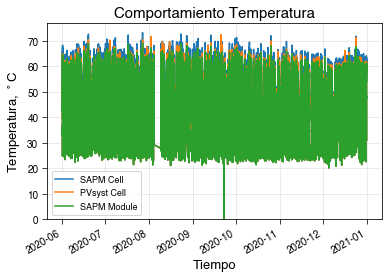

In [ ]:
temp_cell = pvlib.temperature.sapm_cell(poa_global=elpasoDB.poa1, 
                                        temp_air=elpasoDB.temp_air, 
                                        wind_speed=elpasoDB.wind_speed, 
                                        a=-3.56, 
                                        b=-0.075, 
                                        deltaT=3, 
                                        irrad_ref=1000)

temp_mod = pvlib.temperature.sapm_module(poa_global=elpasoDB.poa1, 
                                         temp_air=elpasoDB.temp_air, 
                                         wind_speed=elpasoDB.wind_speed, 
                                         a=-3.56, 
                                         b=-0.075)

temp_cell_pvs = pvlib.temperature.pvsyst_cell(poa_global=elpasoDB.poa1, 
                                              temp_air=elpasoDB.temp_air, 
                                              wind_speed=elpasoDB.wind_speed, 
                                              u_c=29.0, 
                                              u_v=0.0, 
                                              # eta_m=0.1, 
                                              alpha_absorption=0.9)

temp_cell.plot(label='SAPM Cell')
temp_cell_pvs.plot(label='PVsyst Cell')
temp_mod.plot(label='SAPM Module')
plot_specs(title='Comportamiento Temperatura',
          ylabel='Temperatura, $^\circ$C',
          xlabel='Tiempo',
          rot=30, 
          ylim_min=0, ylim_max=None, 
          xlim_min=None, xlim_max=None, 
          loc='best')

### 12.2. Producción DC: Voltaje, Corriente y Potencia

A partir de la función ````pvsystem.calcparams_cec```` se obtienen los parámetros del circuito equivalente que modelan a *Curva I-V* para estimar los parámetros DC en los puntos MPP.

**Info:** https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.pvsystem.calcparams_cec.html.

In [ ]:
def dc_production(effective_irradiance, module_temperature):
    #Single Diode Parameters
    IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_cec(effective_irradiance,
                                                      module_temperature,
                                                      module['alpha_sc'],
                                                      module['a_ref'],
                                                      module['I_L_ref'],
                                                      module['I_o_ref'],
                                                      module['R_sh_ref'],
                                                      module['R_s'],
                                                      module['Adjust'],
                                                      EgRef=1.121,
                                                      dEgdT=-0.0002677)

    curve_info = pvlib.pvsystem.singlediode(photocurrent=IL,
                                      saturation_current=I0,
                                      resistance_series=Rs,
                                      resistance_shunt=Rsh,
                                      nNsVth=nNsVth,
                                      ivcurve_pnts=100,
                                      method='lambertw')

    #Scalating CEC et. al. Single Diode Results
    data_i_sc = pd.Series(curve_info['i_sc'])
    data_v_oc = pd.Series(curve_info['v_oc'])
    data_i_mp = pd.Series(curve_info['i_mp'])
    data_v_mp = pd.Series(curve_info['v_mp'])
    data_p_mp = pd.Series(curve_info['p_mp'])
    data_i_x = pd.Series(curve_info['i_x'])
    data_i_xx = pd.Series(curve_info['i_xx'])

    results_general = pd.DataFrame({'i_sc': data_i_sc, 
                                    'v_oc': data_v_oc,
                                    'i_mp': data_i_mp, 
                                    'v_mp': data_v_mp, 
                                    'p_mp': data_p_mp, 
                                    'i_x': data_i_x,
                                    'i_xx': data_i_xx})

    #DC Dataframe
    datetime_index = effective_irradiance.index

    dc_A = system_A.scale_voltage_current_power(results_general)
    dc_A = dc_A.set_index(datetime_index)

    dc_B = system_B.scale_voltage_current_power(results_general)
    dc_B = dc_B.set_index(datetime_index)
    
    return dc_A, dc_B

### 12.3. Pérdidas

Se introduce un valor de pérdidas de **14.6%** sobre la producción DC que afectará la Potencia AC y Energía Diaria. El valor de 14.6% es el recomendado por el método de estimación de pérdidas de PVWatts y lo valida Marion et al. (2005).

---

[3] A.P. Dobos (2014). PVWatts Version 5 Manual, National Renewable Energy Lab.(NREL), US DOE Office of Energy Efficiency and Renewable Energy (EERE), doi: 10.2172/1158421.

[4] B. Marion, J. Adelstein, K. Boyle, H. Hayden, B. Hammond, T. Fletcher, B. Canada, D. Narang, A. Kimber, L. Mitchell, G. Rich and T. Townsend (2005). Performance parameters for grid-connected PV systems. Conference Record of the IEEE Photovoltaic Specialists Conference, pp. 1601–1606, doi: 10.1109/PVSC.2005.1488451.

---

In [ ]:
def losses(dc_A, dc_B, loss):

    losses = loss/100 #According to the paper Performance Parameters for Grid-Connected PV Systems by NREL

    #Losses System A
    dc_A['i_mp'] = dc_A['i_mp'] - dc_A['i_mp']*losses
    dc_A['p_mp'] = dc_A['p_mp'] - dc_A['p_mp']*losses

    #Losses System B
    dc_B['i_mp'] = dc_B['i_mp'] - dc_B['i_mp']*losses
    dc_B['p_mp'] = dc_B['p_mp'] - dc_B['p_mp']*losses
    
    return dc_A, dc_B

### 12.4. Potencia AC

In [ ]:
#PVlib (SAPM) AC Model
def pvlib_ac_power(dc_A, dc_B, total_inversores=4*12):
    ac_A = pvlib.inverter.sandia(dc_A['v_mp'], dc_A['p_mp'], inverter)
    ac_B = pvlib.inverter.sandia(dc_B['v_mp'], dc_B['p_mp'], inverter)
    
    pvlib_ac = ((ac_A * 7/8) + (ac_B * 1/8)) * total_inversores
    
    pvlib_ac.loc[pvlib_ac < 0] = 0
    pvlib_ac.fillna(value=0, inplace=True)
    
    return pvlib_ac

#PVWatts AC Model
def pvwatts_ac_power(dc_A, dc_B, total_inversores=4*12):
    ac_A = pvlib.inverter.pvwatts(pdc=dc_A.p_mp,
                               pdc0=inverter['pdc0'],
                               eta_inv_nom=inverter['eta_inv_nom'],
                               eta_inv_ref=0.9637) #Default

    ac_B = pvlib.inverter.pvwatts(pdc=dc_B.p_mp,
                               pdc0=inverter['pdc0'],
                               eta_inv_nom=inverter['eta_inv_nom'],
                               eta_inv_ref=0.9637) #Default
 
    #Changing NaN Values from Both Arrays to Zero (To Avoid Setbacks)
    ac_A = ac_A.fillna(0)
    ac_B = ac_B.fillna(0)
    
    #Net AC Power
    pvwatts_ac = ((ac_A * 7/8) + (ac_B * 1/8)) * total_inversores
    
    return pvwatts_ac

### 12.5. Energía Diaria, Semanal y Mensual

In [ ]:
def calc_energy(ac_sim, ac_mea, res):    
    min_to_hour = res/60 #res is data resolution (1h, i.e. 60 min); 60 minutes equivalent to hour
    
    #Resampling Measured Daily Energy    
    ac_mea = ac_mea*min_to_hour
    
    day_mea_energy = pd.DataFrame(ac_mea.resample('1d').sum()) #Daily energy
    day_mea_energy.columns = ['energy']
    
    week_mea_energy = pd.DataFrame(day_mea_energy.resample('1w').sum()) #Weekly energy
    week_mea_energy.columns = ['energy']
    
    month_mea_energy = pd.DataFrame(day_mea_energy.resample('1m').sum()) #Monthly energy
    month_mea_energy.columns = ['energy']

    #Resampling Simulated Daily Energy
    ac_sim = ac_sim*min_to_hour
    
    day_sim_energy = pd.DataFrame(ac_sim.resample('1d').sum())
    day_sim_energy.columns = ['Daily Energy']
    day_sim_energy['Daily Energy'] = day_sim_energy/mega

    day_sim_energy = day_sim_energy.resample('1d').max() #Daily energy
    
    week_sim_energy = pd.DataFrame(day_sim_energy.resample('1w').sum()) #Weekly energy
    week_sim_energy.columns = ['Daily Energy']
    
    month_sim_energy = pd.DataFrame(day_sim_energy.resample('1m').sum()) #Monthly energy
    month_sim_energy.columns = ['Daily Energy']
    
    #Energy Dataframes
    day_energy = pd.DataFrame({'measured': day_mea_energy['energy'], 'simulated': day_sim_energy['Daily Energy']}) #Daily
    week_energy = pd.DataFrame({'measured': week_mea_energy['energy'], 'simulated': week_sim_energy['Daily Energy']}) #Weekly
    month_energy = pd.DataFrame({'measured': month_mea_energy['energy'], 'simulated': month_sim_energy['Daily Energy']}) #Monthly
    
    #Percentage Error
    energyerror = {}
    
    for i in ['day', 'week', 'month']:
        if i == 'day':
            y_true = day_mea_energy
            y_pred = day_sim_energy
        
        elif i == 'week':
            y_true = week_mea_energy
            y_pred = week_sim_energy
        
        else:
            y_true = month_mea_energy
            y_pred = month_sim_energy
    
        energyerror[i] = y_true.copy()
        
        y_true = y_true['energy'].values
        y_pred = y_pred['Daily Energy'].values

        energyerror[i]['perc_error'] = ((np.abs(y_pred - y_true)/y_pred)*100).round(2)
        energyerror[i]['perc_error'] = energyerror[i]['perc_error'].round(decimals=2) 
        
    return day_energy, week_energy, month_energy, energyerror

### 12.6. Simulación Modelo (Resolución 1-min) <span style='color:White'>code:25</span>

In [ ]:
kilo = 1000
mega = 1000000

#DC Production
dc_A, dc_B = dc_production(effective_irradiance=elpasoDB.poa1, 
                           module_temperature=temp_cell)

#Losses
dc_A, dc_B = losses(dc_A=dc_A, dc_B=dc_B, loss=14.6)

#AC Production
pvlib_ac = pvlib_ac_power(dc_A=dc_A, dc_B=dc_B, total_inversores=4*12)
pvwatts_ac = pvwatts_ac_power(dc_A=dc_A, dc_B=dc_B, total_inversores=4*12)

#Energy
pvl_day_energy, pvl_week_energy, pvl_month_energy, pvl_ee = calc_energy(ac_sim=pvlib_ac, ac_mea=elpaso_pac.el_paso, res=1)
pvw_day_energy, pvw_week_energy, pvw_month_energy, pvw_ee = calc_energy(ac_sim=pvwatts_ac, ac_mea=elpaso_pac.el_paso, res=1)

<ipython-input-71-3de16c54161e>:57: RuntimeWarning: invalid value encountered in true_divide
  energyerror[i]['perc_error'] = ((np.abs(y_pred - y_true)/y_pred)*100).round(2)


<ipython-input-79-8beb872b7d3c>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_value,


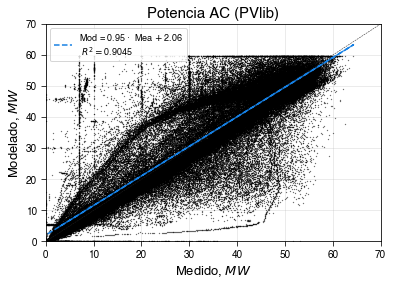

R2:  0.9045
RMSE:  12.55
MAPE:  12.99


<ipython-input-79-8beb872b7d3c>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_value,


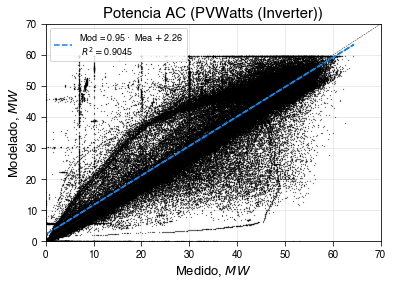

R2:  0.9045
RMSE:  12.53
MAPE:  11.97


In [ ]:
for model in ['PVlib', 'PVWatts (Inverter)']:
    #Least Squares Linear Regression
    x_value = elpaso_pac.el_paso
    
    if model == 'PVlib':
        y_value = pvlib_ac/mega
    else:
        y_value = pvwatts_ac/mega

    ac = pd.DataFrame({'measured': x_value, 
                       'modeled': y_value})

    ac = ac.dropna()

    x_value = ac.measured
    y_value = ac.modeled

    coef = np.polyfit(x_value, y_value, 1)
    poly1d_fn = np.poly1d(coef)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x_value, y_value)

    #Figure
    axis_lim = 70

    x = np.linspace(0, axis_lim, axis_lim)
    y_reg = slope*x + intercept
    
    plt.figure()
    plt.plot(x_value, 
             poly1d_fn(x_value), 
             '--k',
             label=('Mod = ' + f'{slope.round(2)} $· \:$ Mea $+ \:$' + f'{intercept.round(2)} \n $R^2 = $' 
                   + f'{r_value.round(4)}'), 
             color='#1580E4', linewidth=1.5, zorder = 10)

    plt.plot(x_value, y_value, color='black', ls='', marker='.', ms=0.5, fillstyle='none')

    y = x
    plt.plot(x, y, '--', color='#222020', linewidth=0.5)

    plot_specs(title=f'Potencia AC ({model})',
               ylabel='Modelado, $MW$',
               xlabel='Medido, $MW$',
               rot=0, 
               ylim_min=0, ylim_max=axis_lim, 
               xlim_min=0, xlim_max=axis_lim, 
               loc='best')

    plt.show()
    
    #Metrics
    metrics(r2=r_value, measured=x_value, modeled=y_value, store=False)

#### 12.6.2. Energía Diaria <span style='color:White'>code:27</span>

<ipython-input-80-3c682e46866c>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_value,


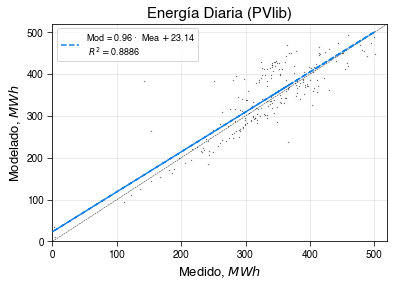

<ipython-input-80-3c682e46866c>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_value,


PVlib
R2:  0.8886
RMSE:  9.1
MAPE:  8.09




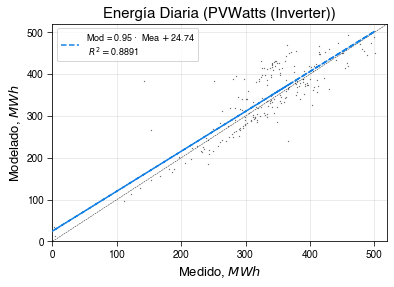

PVWatts (Inverter)
R2:  0.8891
RMSE:  9.13
MAPE:  7.72




In [ ]:
for i in ['PVlib', 'PVWatts (Inverter)']:
    if i == 'PVlib':
        x_value = pvl_day_energy.measured
        y_value = pvl_day_energy.simulated
        ee = pvl_ee['day']
    
    else:
        x_value = pvw_day_energy.measured
        y_value = pvw_day_energy.simulated
        ee = pvw_ee['day']
    
    #Figure
    plt.figure()

    #Least Squares Linear Regression
    coef = np.polyfit(x_value, y_value, 1)
    poly1d_fn = np.poly1d(coef)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x_value, y_value)

    #Figure
    axis_lim = 520

    x = np.linspace(0, axis_lim, axis_lim)
    y_reg = slope*x + intercept

    plt.plot(x_value, 
             poly1d_fn(x_value), 
             '--k',
             label=('Mod = ' + f'{slope.round(2)} $· \:$ Mea $+ \:$' + f'{intercept.round(2)} \n $R^2 = $' 
                   + f'{r_value.round(4)}'), 
             color='#1580E4', linewidth=1.5, zorder = 10)

    plt.plot(x_value, y_value, color='black', ls='', marker='.', ms=0.5, fillstyle='none')

    y = x
    plt.plot(x, y, '--', color='#222020', linewidth=0.5)

    plot_specs(title=f'Energía Diaria ({i})',
               ylabel='Modelado, $MWh$',
               xlabel='Medido, $MWh$',
               rot=0, 
               ylim_min=0, ylim_max=axis_lim, 
               xlim_min=0, xlim_max=axis_lim, 
               loc='best')
    
    plt.show()
    
    #Metrics
    print(i)
    print('R2: ', r_value.round(4))

    metrics_data = pd.DataFrame({'effective_irrad': x_value, 
                                 'poa': y_value})

    y_true = metrics_data.effective_irrad
    y_pred = metrics_data.poa

    rmse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
    rmse = (rmse/np.max(y_true))*100
    print('RMSE: ', np.round(rmse, 2))

    '''
    MAPE requiere filtrar los datos cuando y_true=0 --> (y_true - y_pred)/y_true
    '''
    ee = ee.loc[ee.energy != 0]

    print('MAPE: ', np.round(ee['perc_error'].median(), 2))
    print('\n')

#### 12.6.3. Energía Semanal <span style='color:White'>code:28</span>

<ipython-input-81-46f8d9c1e222>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_value,


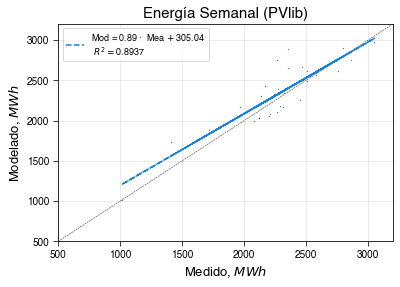

PVlib
R2:  0.8937
RMSE:  6.42
MAPE:  5.37




<ipython-input-81-46f8d9c1e222>:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_value,


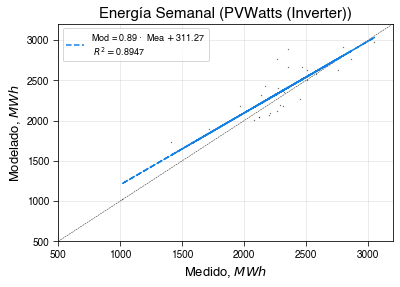

PVWatts (Inverter)
R2:  0.8947
RMSE:  6.48
MAPE:  5.27




In [ ]:
for i in ['PVlib', 'PVWatts (Inverter)']:
    if i == 'PVlib':
        x_value = pvl_week_energy.measured
        y_value = pvl_week_energy.simulated
        ee = pvl_ee['week']
    
    else:
        x_value = pvw_week_energy.measured
        y_value = pvw_week_energy.simulated
        ee = pvw_ee['week']
    
    #Figure
    plt.figure()

    #Least Squares Linear Regression
    coef = np.polyfit(x_value, y_value, 1)
    poly1d_fn = np.poly1d(coef)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x_value, y_value)

    #Figure
    axis_lim = 3200

    x = np.linspace(0, axis_lim, axis_lim)
    y_reg = slope*x + intercept

    plt.plot(x_value, 
             poly1d_fn(x_value), 
             '--k',
             label=('Mod = ' + f'{slope.round(2)} $· \:$ Mea $+ \:$' + f'{intercept.round(2)} \n $R^2 = $' 
                   + f'{r_value.round(4)}'), 
             color='#1580E4', linewidth=1.5, zorder = 10)

    plt.plot(x_value, y_value, color='black', ls='', marker='.', ms=0.5, fillstyle='none')

    y = x
    plt.plot(x, y, '--', color='#222020', linewidth=0.5)

    plot_specs(title=f'Energía Semanal ({i})',
               ylabel='Modelado, $MWh$',
               xlabel='Medido, $MWh$',
               rot=0, 
               ylim_min=500, ylim_max=axis_lim, 
               xlim_min=500, xlim_max=axis_lim, 
               loc='best')
    
    plt.show()
    
    #Metrics
    print(i)
    print('R2: ', r_value.round(4))

    metrics_data = pd.DataFrame({'effective_irrad': x_value, 
                                 'poa': y_value})

    y_true = metrics_data.effective_irrad
    y_pred = metrics_data.poa

    rmse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
    rmse = (rmse/np.max(y_true))*100
    print('RMSE: ', np.round(rmse, 2))

    '''
    MAPE requiere filtrar los datos cuando y_true=0 --> (y_true - y_pred)/y_true
    '''
    ee = ee.loc[ee.energy != 0]

    print('MAPE: ', np.round(ee['perc_error'].median(), 2))
    print('\n')

#### 12.6.4. Energía Mensual <span style='color:White'>code:29</span>

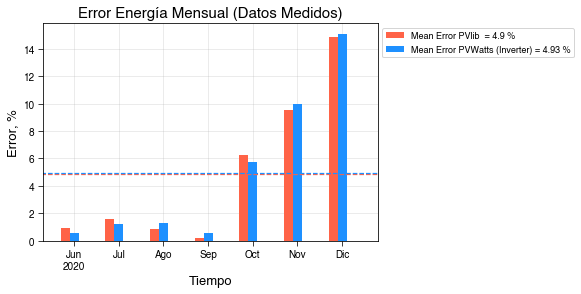

In [ ]:
#Energy Error Comparison Plot
bar_width = 0.1
width = bar_width*2

months = ['Jun\n2020', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

x = np.arange(len(months))

r1 = np.arange(len(months))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

#Mean Error Values
pvlib_meanerror = round(pvl_ee['month']['perc_error'].mean(), 2)
pvwatts_meanerror = round(pvw_ee['month']['perc_error'].mean(), 2)

#Bar Plots
hor, ver = 13, 5
#plt.figure(figsize=(hor,ver))

plt.bar(r1, pvl_ee['month']['perc_error'], width, 
        label='Mean Error PVlib  = ' + f'{pvlib_meanerror}' + ' %', color='tomato', linewidth=2)

plt.bar(r3, pvw_ee['month']['perc_error'], width, 
        label='Mean Error PVWatts (Inverter) = ' + f'{pvwatts_meanerror}' + ' %', color='dodgerblue', linewidth=2)

#Horizontal Lines
plt.hlines(y=0, xmin=-1, xmax=x[-1]+1, colors='black', linestyles='solid', linewidth=0.5) #Zero
plt.hlines(y=pvlib_meanerror, xmin=-1, xmax=x[-1]+1, colors='tomato', linestyles='--', linewidth=1.25)
plt.hlines(y=pvwatts_meanerror, xmin=-1, xmax=x[-1]+1, colors='dodgerblue', linestyles='--', linewidth=1.25)

plt.xticks(r3, months)
plot_specs(title='Error Energía Mensual (Datos Medidos)',
           ylabel='Error, %',
           xlabel='Tiempo',
           rot=0, 
           ylim_min=0, ylim_max=None, 
           xlim_min=-0.5, xlim_max=7, 
           loc='best')
plt.legend(loc='best', bbox_to_anchor=(1,1), fontsize=9);

#### 13.1.1. Potencia AC <span style='color:White'>code:34</span>

In [ ]:
years = [1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,
         2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]
# years = [2020]

li = []

for year in years:
    psm3data, header = pvlib.iotools.get_psm3(lat, lon, api_key, email, 
                                                   names=year, interval=60)
    li.append(psm3data)

elpaso_psm3 = pd.concat(li, axis=0)

In [ ]:
# Si quiere guardar los datos en un archivo local para no tener que volver
# a descargarlos cuando reinicie el cuaderno

elpaso_psm3.reset_index().to_feather('./elpaso_psm3.feather')

In [ ]:
# Para leer el archivo guardado en la celda anterior.

elpaso_psm3 = pd.read_feather('./elpaso_psm3.feather')
elpaso_psm3.index = pd.to_datetime(elpaso_psm3.index)
elpaso_psm3 = elpaso_psm3.set_index('index')


In [ ]:
elpaso_psm3.head()

,Year,Month,Day,Hour,Minute,Temperature,Dew Point,DHI,DNI,GHI,Surface Albedo,Pressure,Wind Direction,Wind Speed
index,,,,,,,,,,,,,,
1998-01-01 00:30:00-05:00,1998,1,1,0,30,24.0,17.0,0.0,0.0,0.0,0.193,990.0,15.1,0.2
1998-01-01 01:30:00-05:00,1998,1,1,1,30,24.0,17.0,0.0,0.0,0.0,0.193,990.0,1.6,0.2
1998-01-01 02:30:00-05:00,1998,1,1,2,30,23.0,17.0,0.0,0.0,0.0,0.193,990.0,353.1,0.2
1998-01-01 03:30:00-05:00,1998,1,1,3,30,23.0,17.0,0.0,0.0,0.0,0.193,990.0,346.4,0.2
1998-01-01 04:30:00-05:00,1998,1,1,4,30,23.0,17.0,0.0,0.0,0.0,0.193,990.0,346.3,0.1


In [ ]:
psm3_columns = elpaso_psm3.columns
print(psm3_columns)

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Dew Point',
       'DHI', 'DNI', 'GHI', 'Surface Albedo', 'Pressure', 'Wind Direction',
       'Wind Speed'],
      dtype='object')


In [ ]:
psm3_columns_rename = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'temp_air', 'Dew Point', 'dhi', 'dni', 'ghi', 'albedo', 'Pressure', 'Wind Direction', 'wind_speed']
elpaso_psm3.columns = psm3_columns_rename

In [ ]:
from datetime import timedelta

elpaso_psm3.index = elpaso_psm3.index - timedelta(minutes=30)

In [ ]:
elpaso_psm3.head()

,Year,Month,Day,Hour,Minute,temp_air,Dew Point,dhi,dni,ghi,albedo,Pressure,Wind Direction,wind_speed
index,,,,,,,,,,,,,,
1998-01-01 00:00:00-05:00,1998,1,1,0,30,24.0,17.0,0.0,0.0,0.0,0.193,990.0,15.1,0.2
1998-01-01 01:00:00-05:00,1998,1,1,1,30,24.0,17.0,0.0,0.0,0.0,0.193,990.0,1.6,0.2
1998-01-01 02:00:00-05:00,1998,1,1,2,30,23.0,17.0,0.0,0.0,0.0,0.193,990.0,353.1,0.2
1998-01-01 03:00:00-05:00,1998,1,1,3,30,23.0,17.0,0.0,0.0,0.0,0.193,990.0,346.4,0.2
1998-01-01 04:00:00-05:00,1998,1,1,4,30,23.0,17.0,0.0,0.0,0.0,0.193,990.0,346.3,0.1


In [ ]:
elpaso_psm3_mcp = elpaso_psm3[elpaso_psm3.index > "2020-06-01 00:00:00-05:00"]
#Calculate solar position parameters
solpos_mcp = location.get_solarposition(times=elpaso_psm3_mcp.index,
                                    method='nrel_numpy')

elpaso_psm3_mcp = elpaso_psm3_mcp.loc[solpos_mcp['apparent_elevation'] > 0, :]
solpos_mcp = solpos_mcp.loc[solpos_mcp['apparent_elevation'] > 0, :]

elpaso_psm3_mcp

,Year,Month,Day,Hour,Minute,temp_air,Dew Point,dhi,dni,ghi,albedo,Pressure,Wind Direction,wind_speed
index,,,,,,,,,,,,,,
2020-06-01 06:00:00-05:00,2020,6,1,6,30,26.0,24.6,76.0,166.0,111.0,0.18,1001.0,111.0,0.1
2020-06-01 07:00:00-05:00,2020,6,1,7,30,27.6,24.5,172.0,224.0,271.0,0.18,1001.0,146.0,0.1
2020-06-01 08:00:00-05:00,2020,6,1,8,30,29.3,23.4,282.0,89.0,339.0,0.18,1001.0,146.0,0.0
2020-06-01 09:00:00-05:00,2020,6,1,9,30,31.1,22.3,380.0,180.0,525.0,0.18,1001.0,136.0,0.0
2020-06-01 10:00:00-05:00,2020,6,1,10,30,32.6,21.5,337.0,455.0,755.0,0.18,1001.0,150.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 13:00:00-05:00,2020,12,31,13,30,36.3,16.0,98.0,926.0,810.0,0.18,995.0,220.0,0.0
2020-12-31 14:00:00-05:00,2020,12,31,14,30,35.8,16.1,91.0,882.0,664.0,0.18,994.0,172.0,0.0
2020-12-31 15:00:00-05:00,2020,12,31,15,30,34.7,16.5,80.0,798.0,464.0,0.18,994.0,129.0,0.0


In [ ]:
elpasoDB_60min
elpasoDB_60min_mcp = elpasoDB_60min[elpasoDB_60min.index > "2020-06-01 00:00:00-05:00"]
#Calculate solar position parameters
solpos_mcp = location.get_solarposition(times=elpasoDB_60min.index,
                                    method='nrel_numpy')

elpasoDB_60min_mcp = elpasoDB_60min_mcp.loc[solpos_mcp['apparent_elevation'] > 0, :]
solpos_mcp = solpos_mcp.loc[solpos_mcp['apparent_elevation'] > 0, :]

elpasoDB_60min

,temp_air,pressure,humidity,wind_direction,wind_speed,ghi_2,ghi,dhi,rain,poa1,...,poa5,poa6,poa7,poa8,poa9,poa10,poa11,poa12,poa_mean,dni
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-06-01 05:00:00-05:00,24.919680,1005.980015,97.261743,34.485962,0.630128,15.094412,14.694872,11.959705,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,85.631555
2020-06-01 06:00:00-05:00,25.514718,1006.141891,94.791844,69.180366,0.493860,122.587260,116.779828,93.093360,0.103333,141.237631,...,155.329329,155.329329,155.329329,159.873660,159.873660,155.735133,143.963133,143.963133,149.904111,132.714761
2020-06-01 07:00:00-05:00,26.768879,1006.740057,86.930553,122.429792,0.148471,205.729450,200.844985,160.133584,0.000000,173.021353,...,189.704854,189.704854,189.704854,187.353840,187.353840,163.554182,194.994056,194.994056,184.467892,103.373528
2020-06-01 08:00:00-05:00,27.715400,1007.105030,82.420734,143.542899,0.287264,279.249809,271.899395,222.257436,0.000000,245.555582,...,263.934447,263.934447,263.934447,252.114648,252.114648,226.686017,242.552894,242.552894,249.363810,88.552875
2020-06-01 09:00:00-05:00,29.172182,1007.194214,74.525395,220.674420,0.358406,450.276014,437.162579,353.589068,0.000000,515.886620,...,514.780418,514.780418,514.780418,454.367489,454.367489,407.014902,438.380915,438.380915,477.415711,120.074383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 13:00:00-05:00,35.463398,1001.130247,28.690251,183.856582,1.681613,779.040223,790.779975,100.219687,0.000000,913.625726,...,793.286215,793.286215,793.286215,820.428735,820.428735,826.290248,790.157688,790.157688,838.483885,883.024562
2020-12-31 14:00:00-05:00,35.571274,1000.338839,28.158247,165.922099,1.617595,625.963057,640.549372,578.097620,0.000000,895.869675,...,640.963997,640.963997,640.963997,675.845330,675.845330,679.054915,655.321997,655.321997,735.068948,63.025892
2020-12-31 15:00:00-05:00,35.666147,1000.021379,27.468488,223.857510,1.268416,417.142399,436.245258,470.432859,0.000000,833.454602,...,437.715689,437.715689,437.715689,480.824783,480.824783,481.151206,455.461033,455.461033,580.951356,-112.560839


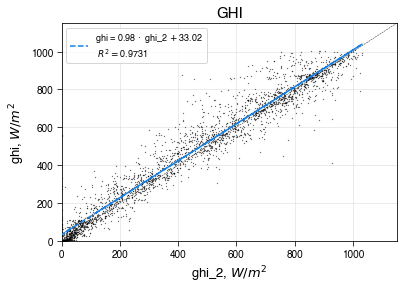

R2:  0.9731
RMSE:  7.22
MAPE:  8.03


In [ ]:
irrads = pd.DataFrame({'ghi': elpasoDB_60min_mcp['ghi'], 
                           'ghi_2': elpaso_psm3_mcp['ghi']})

irrads = irrads.dropna()
#Least Squares Linear Regression
x_value = irrads.ghi
y_value = irrads.ghi_2

coef = np.polyfit(x_value, y_value, 1)
poly1d_fn = np.poly1d(coef)

slope, intercept, r_value, p_value, std_err = stats.linregress(x_value, 
                                                                  y_value)

#Figure
axis_lim = 1150

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope*x + intercept
                        
plt.figure()
plt.plot(x_value, 
            poly1d_fn(x_value), 
            '--',
            label=('ghi = ' + 
                  f'{slope.round(2)} $· \:$ ghi_2 $+ \:$' + 
                  f'{intercept.round(2)} \n $R^2 = $' 
                  + f'{r_value.round(4)}'), 
            color='#1580E4', linewidth=1.5, zorder = 10)

plt.plot(x_value, y_value, color='black', ls='', 
            marker='.', ms=0.5, fillstyle='none')

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plot_specs(title=f'GHI',
            ylabel='ghi, $W/m^2$',
            xlabel='ghi_2, $W/m^2$',
            rot=0, 
            ylim_min=0, ylim_max=axis_lim, 
            xlim_min=0, xlim_max=axis_lim, 
            loc='best')
                        
plt.show()
                        
#METRICS
metrics(r2=r_value, measured=x_value, modeled=y_value, store=False)

In [ ]:
# MCP

variance_ref = elpaso_psm3_mcp.std().ghi
mean_ref = elpaso_psm3_mcp.mean().ghi
variance_obj = elpasoDB_60min_mcp.std().ghi
mean_obj = elpasoDB_60min_mcp.mean().ghi
print(variance_ref,mean_ref,variance_obj,mean_obj)

308.10041808246757 465.12926459438967 306.32885428618124 443.08423524255437


In [ ]:
elpaso_psm3['ghi_mcp'] = ((mean_obj-(variance_obj/variance_ref)*mean_ref) 
                              + (variance_obj/variance_ref)*elpaso_psm3['ghi'])

In [ ]:
solpos_corr = location.get_solarposition(times=elpaso_psm3.index,
                                    method='nrel_numpy')
elpaso_psm3 = elpaso_psm3.loc[solpos_corr['apparent_elevation'] > 0, :]
solpos_corr = location.get_solarposition(times=elpaso_psm3.index,
                                    method='nrel_numpy')
elpaso_psm3_corr = elpaso_psm3[elpaso_psm3.index > "2020-06-01 00:00:00-05:00"]
elpaso_psm3_corr

,Year,Month,Day,Hour,Minute,temp_air,Dew Point,dhi,dni,ghi,albedo,Pressure,Wind Direction,wind_speed,ghi_mcp
index,,,,,,,,,,,,,,,
2020-06-01 06:00:00-05:00,2020,6,1,6,30,26.0,24.6,76.0,166.0,111.0,0.18,1001.0,111.0,0.1,90.991198
2020-06-01 07:00:00-05:00,2020,6,1,7,30,27.6,24.5,172.0,224.0,271.0,0.18,1001.0,146.0,0.1,250.071205
2020-06-01 08:00:00-05:00,2020,6,1,8,30,29.3,23.4,282.0,89.0,339.0,0.18,1001.0,146.0,0.0,317.680208
2020-06-01 09:00:00-05:00,2020,6,1,9,30,31.1,22.3,380.0,180.0,525.0,0.18,1001.0,136.0,0.0,502.610717
2020-06-01 10:00:00-05:00,2020,6,1,10,30,32.6,21.5,337.0,455.0,755.0,0.18,1001.0,150.0,0.0,731.288227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 13:00:00-05:00,2020,12,31,13,30,36.3,16.0,98.0,926.0,810.0,0.18,995.0,220.0,0.0,785.971979
2020-12-31 14:00:00-05:00,2020,12,31,14,30,35.8,16.1,91.0,882.0,664.0,0.18,994.0,172.0,0.0,640.811473
2020-12-31 15:00:00-05:00,2020,12,31,15,30,34.7,16.5,80.0,798.0,464.0,0.18,994.0,129.0,0.0,441.961464


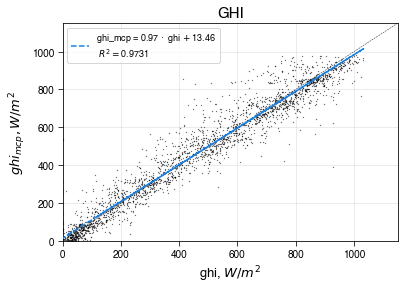

R2:  0.9731
RMSE:  6.87
MAPE:  8.67


In [ ]:
irrads = pd.DataFrame({'ghi': elpasoDB_60min_mcp['ghi'], 
                           'ghi_mcp': elpaso_psm3_corr['ghi_mcp']})

irrads = irrads.dropna()
#Least Squares Linear Regression
x_value = irrads.ghi
y_value = irrads.ghi_mcp

coef = np.polyfit(x_value, y_value, 1)
poly1d_fn = np.poly1d(coef)

slope, intercept, r_value, p_value, std_err = stats.linregress(x_value, 
                                                                  y_value)

#Figure
axis_lim = 1150

x = np.linspace(0, axis_lim, axis_lim)
y_reg = slope*x + intercept
                        
plt.figure()
plt.plot(x_value, 
            poly1d_fn(x_value), 
            '--',
            label=('ghi_mcp = ' + 
                  f'{slope.round(2)} $· \:$ ghi $+ \:$' + 
                  f'{intercept.round(2)} \n $R^2 = $' 
                  + f'{r_value.round(4)}'), 
            color='#1580E4', linewidth=1.5, zorder = 10)

plt.plot(x_value, y_value, color='black', ls='', 
            marker='.', ms=0.5, fillstyle='none')

y = x
plt.plot(x, y, '--', color='#222020', linewidth=0.5)

plot_specs(title=f'GHI',
            ylabel='$ghi_{mcp}, W/m^2$',
            xlabel='ghi, $W/m^2$',
            rot=0, 
            ylim_min=0, ylim_max=axis_lim, 
            xlim_min=0, xlim_max=axis_lim, 
            loc='best')
                        
plt.show()
                        
#METRICS
metrics(r2=r_value, measured=x_value, modeled=y_value, store=False)

In [ ]:
kilo = 1000
mega = 1000000

#Original DISC: Relative Airmass
disc = pvlib.irradiance.disc(ghi=elpaso_psm3.ghi_mcp, 
                             solar_zenith=solpos_corr.apparent_zenith, 
                             datetime_or_doy=elpaso_psm3.index, 
                             pressure=None, #Absolute Airmass: 101325, Relative Airmass: None (elpasoDB.pressure*100)
                             min_cos_zenith=0.065, 
                             max_zenith=87, #80
                             max_airmass=12) #Max airmass value to allow in Kt calc; value 12 comes from original paper.

disc['dhi'] = elpaso_psm3.ghi - disc.dni*np.cos(np.radians(solpos_corr.apparent_zenith))

tracker = pvlib.tracking.singleaxis(apparent_zenith=solpos_corr.apparent_zenith, 
                                    apparent_azimuth=solpos_corr.azimuth, 
                                    axis_tilt=0,
                                    axis_azimuth=180, #Heading south
                                    max_angle=45, 
                                    backtrack=True, 
                                    gcr=0.2857142857142857)

airmass = location.get_airmass(times=elpaso_psm3.index, 
                               solar_position=solpos_corr, 
                               model='kastenyoung1989')
                              
etr_nrel = pvlib.irradiance.get_extra_radiation(datetime_or_doy=elpaso_psm3.index, 
                                          method='NREL', 
                                          solar_constant=1361);

surface_albedo = pvlib.irradiance.SURFACE_ALBEDOS['soil']; # Check the surfaces albedo list with print(irradiance.SURFACE_ALBEDOS.items()) function

poa_perez = pvlib.irradiance.get_total_irradiance(surface_tilt=tracker.surface_tilt, 
                                            surface_azimuth=tracker.surface_azimuth, 
                                            solar_zenith=solpos_corr.apparent_zenith, 
                                            solar_azimuth=solpos_corr.azimuth, 
                                            dni=disc.dni, 
                                            ghi=elpaso_psm3.ghi_mcp, 
                                            dhi=disc.dhi, 
                                            dni_extra=etr_nrel, 
                                            airmass=airmass.airmass_relative, 
                                            albedo=surface_albedo, 
                                            surface_type='soil', 
                                            model='perez', 
                                            model_perez='allsitescomposite1990')

temp_cell = pvlib.temperature.sapm_cell(poa_global=poa_perez.poa_global, 
                                        temp_air=elpaso_psm3.temp_air, 
                                        wind_speed=elpaso_psm3.wind_speed, 
                                        a=-3.56, 
                                        b=-0.075, 
                                        deltaT=3, 
                                        irrad_ref=1000)

#DC Production
dc_A, dc_B = dc_production(effective_irradiance=poa_perez.poa_global, 
                           module_temperature=temp_cell)

#Losses
dc_A, dc_B = losses(dc_A=dc_A, dc_B=dc_B, loss=14.6)

#AC Production
pvlib_ac = pvlib_ac_power(dc_A=dc_A, dc_B=dc_B, total_inversores=4*12)



In [ ]:
pvlib_ac

index
1998-01-01 07:00:00-05:00    3.286029e+07
1998-01-01 08:00:00-05:00    5.013423e+07
1998-01-01 09:00:00-05:00    5.236642e+07
1998-01-01 10:00:00-05:00    5.085711e+07
1998-01-01 11:00:00-05:00    4.868358e+07
                                 ...     
2020-12-31 13:00:00-05:00    4.453064e+07
2020-12-31 14:00:00-05:00    4.124771e+07
2020-12-31 15:00:00-05:00    3.331159e+07
2020-12-31 16:00:00-05:00    1.844341e+07
2020-12-31 17:00:00-05:00    7.647598e+05
Length: 103246, dtype: float64

In [ ]:
pvlib_ac.max()

58758833.15746997

In [ ]:
elpaso_p99 = np.percentile(pvlib_ac, 99.9)
print(elpaso_p99)
print(elpaso_p99.max())

57112453.637424655
57112453.637424655


Text(0, 0.5, '$p$')

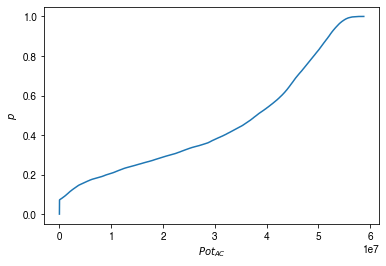

In [ ]:
pot_pvlib_ac = np.sort(pvlib_ac)

pot_pvlib_ac_max = np.max(pvlib_ac)

# calculate the proportional values of samples
p = 1. * np.arange(len(pvlib_ac)) / (len(pvlib_ac) - 1)

# plot the sorted data:
plt.plot(pot_pvlib_ac, p)
plt.xlabel('$Pot_{AC}$')
plt.ylabel('$p$')